In [33]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np
import sys
from gen_catalyst_design.db import Database, get_atoms_list_db, load_data_from_db
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [2]:
miller_index = "100"
pth_header = f"results/Rh_Cu_Au_Pd/miller_index_{miller_index}"
run_ids = [0,1,2,3]
datadicts = []
for run_id in run_ids:
    filename = f"runID_{run_id}_results.db"
    database = Database.establish_connection(filename=filename, miller_index=miller_index, pth_header=pth_header)
    datadicts += load_data_from_db(database=database)

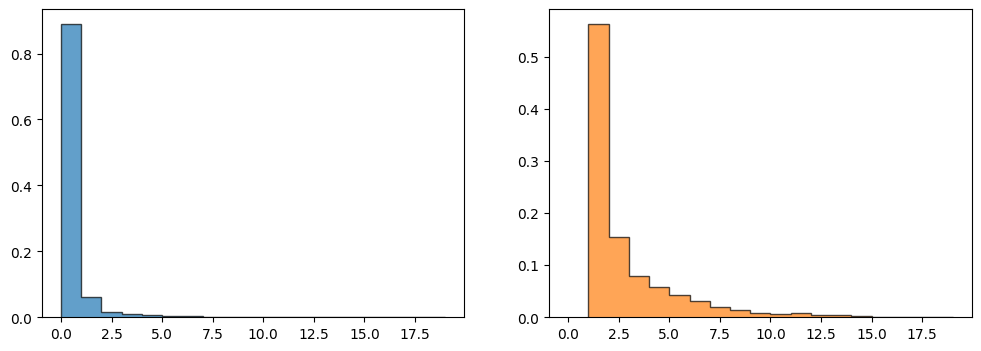

In [3]:
fig, axs = plt.subplots(1,2, figsize=(12,4), sharex=True)
rates = np.array([datadict["rate"] for datadict in datadicts])
rate_interval = 1.0
rate_max = np.max(rates)

for ax, rate_min, color in zip(axs, [0.0, 1.0], ["C0", "C1"]):
    bins = np.arange(rate_min, rate_max, rate_interval)
    hist, edges = np.histogram(rates, bins=bins)
    #diff = bins[1]-bins[0]
    ax.stairs(hist/np.sum(hist), edges=edges, fill=True, alpha=0.7, edgecolor="k", linewidth=1, color=color)

In [38]:
def element_to_onehot(element, mapping_dict):
    onehot = np.zeros(len(mapping_dict))
    onehot[mapping_dict[element]] +=1
    return onehot

def get_onehots(datadicts, element_pool):
    mapping_dict = {element:i for i, element in enumerate(element_pool)}
    result_onehots = []
    for datadict in datadicts:
        elements = datadict["elements"]
        onehots = np.hstack([element_to_onehot(element=element, mapping_dict=mapping_dict) for element in elements])
        result_onehots.append(onehots)
    return np.vstack(result_onehots)

def assign_classes(datadicts, classes, num_classes):
    class_divs = {}
    for i in range(num_classes):
        for j, datadict in enumerate(datadicts):
            rate = datadict["rate"]
            if rate > classes[i] and rate < classes[i+1]:
                if i in class_divs:
                    class_divs[i].append(j)
                else:
                    class_divs[i] = [j]
    return class_divs


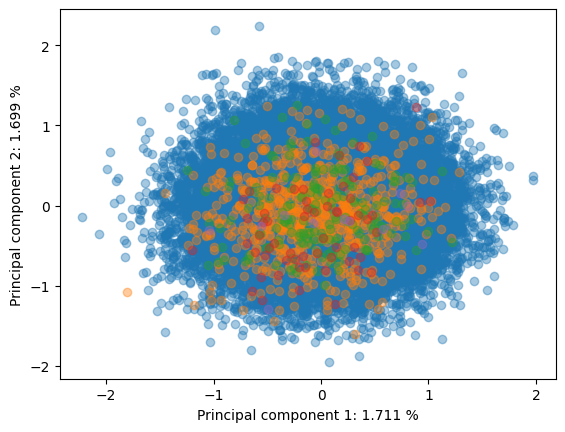

In [39]:
fig, ax = plt.subplots()
element_pool = ["Rh", "Cu", "Au", "Pd"]
onehots = get_onehots(datadicts=datadicts, element_pool=element_pool)
pca = PCA(n_components=2)
transformed = pca.fit_transform(onehots)
ax.set_xlabel(f"Principal component 1: {(pca.explained_variance_ratio_[0]*100).round(3)} %")
ax.set_ylabel(f"Principal component 2: {(pca.explained_variance_ratio_[1]*100).round(3)} %")
num_classes = 5
rate_min = 0.0
classes = np.linspace(rate_min, rate_max, num_classes+1)
class_divs = assign_classes(datadicts=datadicts, classes=classes, num_classes=num_classes)

for div in class_divs:
    indices = class_divs[div]
    ax.plot(transformed[indices][:,0], transformed[indices][:,1], 'o', alpha=0.4, color=f"C{div}")

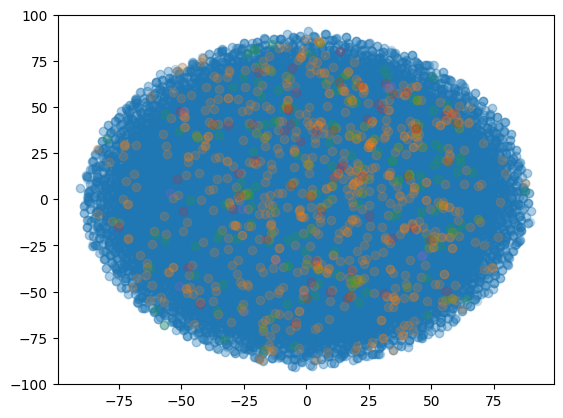

In [ ]:
fig, ax = plt.subplots()
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random').fit_transform(onehots)
for div in class_divs:
    indices = class_divs[div]
    ax.plot(X_embedded[indices][:,0], X_embedded[indices][:,1], 'o', alpha=0.2, color=f"C{div}")

In [40]:
def filter_datadicts(datadicts, rate_min):
    filtered_dicts = []
    for datadict in datadicts:
        rate = datadict["rate"]
        if rate >= rate_min:
            filtered_dicts.append(datadict)
    return filtered_dicts

[ 0.          3.80586852  7.61173704 11.41760555 15.22347407 19.02934259]


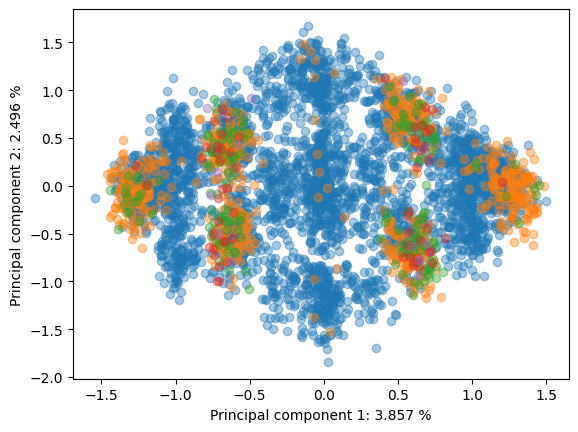

In [64]:
fig, ax = plt.subplots()
element_pool = ["Rh", "Cu", "Au", "Pd"]

filtered_datadicts = filter_datadicts(datadicts=datadicts, rate_min=1.0)

onehots = get_onehots(datadicts=filtered_datadicts, element_pool=element_pool)
pca = PCA(n_components=2)
transformed = pca.fit_transform(onehots)
ax.set_xlabel(f"Principal component 1: {(pca.explained_variance_ratio_[0]*100).round(3)} %")
ax.set_ylabel(f"Principal component 2: {(pca.explained_variance_ratio_[1]*100).round(3)} %")
num_classes = 5
rate_min = 0.0
classes = np.linspace(rate_min, rate_max, num_classes+1)
print(classes)
class_divs = assign_classes(datadicts=filtered_datadicts, classes=classes, num_classes=num_classes)
for div in class_divs:
    indices = class_divs[div]
    ax.plot(transformed[indices][:,0], transformed[indices][:,1], 'o', alpha=0.4, color=f"C{div}")

In [65]:
fitltered_rates = [datadict["rate"] for datadict in filtered_datadicts]
print(min(fitltered_rates))

1.0004088376738305


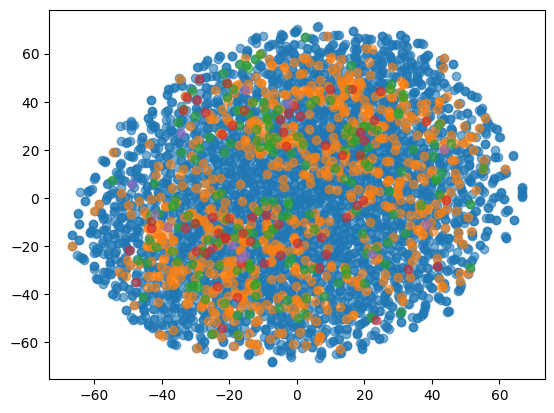

In [66]:
fig, ax = plt.subplots()
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random').fit_transform(onehots)
for div in class_divs:
    indices = class_divs[div]
    ax.plot(X_embedded[indices][:,0], X_embedded[indices][:,1], 'o', alpha=0.6, color=f"C{div}")